### Attempting to remove stopwords before splitting the line lyrics by Token

In [44]:
# Import libraries and upload OHCO (by line) #
import pandas as pd
import numpy as np
import os
#os.chdir('/Users/nickbruno/Documents/spring_2019/DS5559/project/code')

df = pd.read_csv('artist_song_verse_line_OHCO_df.csv') # includes corpus with no duplicate song names

In [45]:
import nltk

In [46]:
df.head()

,artist_id,song_id,verse_num,line_num,Line
0,0,0,0,0,"Look at her face, it's a wonderful face"
1,0,0,0,1,And it means something special to me
2,0,0,0,2,Look at the way that she smiles when she sees me
3,0,0,0,3,How lucky can one fellow be?
4,0,0,1,0,"She's just my kind of girl, she makes me feel ..."


In [47]:
# Create a subset of 100,000 lines #
len(df) / df.artist_id.nunique() # 2000 lines per artist

2138.6666666666665

In [48]:
artist_id_list = df.artist_id.unique().tolist()
df.artist_id.nunique() # 639 artists

639

In [58]:
import random
random.seed(69)
sub_artist = random.sample(artist_id_list, k=40)
sub_artist

[38,
 98,
 172,
 68,
 622,
 354,
 337,
 564,
 426,
 477,
 440,
 582,
 450,
 533,
 330,
 575,
 563,
 452,
 147,
 424,
 403,
 65,
 295,
 152,
 202,
 319,
 218,
 517,
 214,
 105,
 101,
 398,
 640,
 66,
 270,
 624,
 383,
 41,
 64,
 96]

In [59]:
# Subset to create smaller corpus #
subset_df = df[df.artist_id.isin(sub_artist)]

In [60]:
len(subset_df)

88663

In [61]:
subset_df = subset_df.set_index(['artist_id','song_id','verse_num','line_num'])
subset_df.head()

Line
artist_id song_id verse_num line_num                                                   
38        2691    0         0         Have you ever thought about your soul - can it...
                            1         Or perhaps you think that when you're dead you...
                            2         Is God just a thought within your head or is h...
                            3         Is Christ just a name that you read in a book ...
                  1         0         When you think about death do you lose your br...

In [62]:
# Create a bag of tokens #
TOKEN_PAT = r'(\W+)'
token_subset_df = subset_df.Line.str.split(TOKEN_PAT, expand=True)\
    .stack()\
    .to_frame()\
    .rename(columns={0:'token_str'})
token_subset_df.index.names = ['artist_id','song_id','verse_num','line_num','token_num']

In [63]:
token_subset_df.head()

token_str
artist_id song_id verse_num line_num token_num          
38        2691    0         0        0              Have
                                     1                  
                                     2               you
                                     3                  
                                     4              ever

In [64]:
# Remove numbers and punctuation #
token_subset_df['punc'] = token_subset_df.token_str.str.match(r'^[\W_]*$').astype('int')
token_subset_df['num'] = token_subset_df.token_str.str.match(r'\d').astype('int')

In [65]:
# Create subsets where punc and num == 0
no_punc = token_subset_df[token_subset_df.punc == 0]
no_num = no_punc[no_punc.num == 0]

In [66]:
# change each word to lowercase #
no_num.token_str = no_num.token_str.str.lower()

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [67]:
# Remove stopwords #
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/kk4ze/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [68]:
final_token_df = no_num[-no_num.token_str.isin(stop)]

In [69]:
final_token_df.head(10)

token_str  punc  num
artist_id song_id verse_num line_num token_num                     
38        2691    0         0        4              ever     0    0
                                     6           thought     0    0
                                     12             soul     0    0
                                     20            saved     0    0
                            1        2           perhaps     0    0
                                     6             think     0    0
                                     16             dead     0    0
                                     22             stay     0    0
                                     28            grave     0    0
                            2        2               god     0    0

In [70]:
final_token_df = final_token_df.drop(columns=['punc','num'])

In [71]:
len(final_token_df)

267761

In [23]:
# Write out to csv
final_token_df.to_csv('token_corpus_one_hundred_artists.csv')

In [72]:
df = final_token_df

### Now that we have our token table, we can use TFIDF for analysis

In [73]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('tagsets')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/kk4ze/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/kk4ze/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /home/kk4ze/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package tagsets to /home/kk4ze/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.
[nltk_data] Downloading package wordnet to /home/kk4ze/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [74]:
# Stem each word #
stemmer = nltk.stem.porter.PorterStemmer()
df['port_stem'] = df.token_str.apply(lambda x: stemmer.stem(x))

In [75]:
# Find teh word frequency
token_counts = df.port_stem.str.lower().value_counts()

In [76]:
token_counts # love, like, time

love             4944
know             3567
oh               3242
like             2501
get              2292
go               2256
time             2252
come             2205
got              2161
want             2151
see              2032
one              1957
yeah             1921
babi             1899
say              1852
let              1771
make             1724
never            1664
way              1609
feel             1591
day              1541
gonna            1509
take             1507
heart            1408
girl             1340
need             1322
caus             1321
look             1296
back             1287
give             1229
                 ... 
disdain             1
aladin              1
tint                1
grom                1
ethic               1
palermo             1
hellbound           1
stal                1
afflict             1
symptom             1
barsha              1
pussyat             1
glimmer             1
slogan              1
tether    

In [77]:
# Create a vocab table #
vocab = df.port_stem.value_counts().to_frame()\
    .reset_index()\
    .rename(columns={'index':'port_stem', 'port_stem':'n'})
vocab = vocab.sort_values('port_stem').reset_index()
vocab.index.name = 'term_id'
vocab = vocab.drop('index', 1)

In [78]:
vocab.sort_values('n', ascending=False).head(25)

,port_stem,n
term_id,,
5874,love,4944
5460,know,3567
7003,oh,3242
5734,like,2501
4013,get,2292
4107,go,2256
10323,time,2252
1917,come,2205
4159,got,2161


In [79]:
K = df
V = vocab

In [80]:
K['term_id'] = K['port_stem'].map(V.reset_index().set_index('port_stem').term_id).fillna(-1).astype('int')

In [81]:
K.head()

token_str port_stem  term_id
artist_id song_id verse_num line_num token_num                             
38        2691    0         0        4              ever      ever     3253
                                     6           thought   thought    10250
                                     12             soul      soul     9419
                                     20            saved      save     8696
                            1        2           perhaps    perhap     7442

In [82]:
OHCO = ['artist_id', 'song_id', 'verse_num', 'line_num','token_num']
SONG=OHCO[1:2]

In [83]:
# Create a bag of words per song #
BOW = K.groupby(SONG+['term_id'])['term_id'].count()
BOW.head()

song_id  term_id
2691     132        1
         824        2
         1085       1
         1186       1
         1590       1
Name: term_id, dtype: int64

In [84]:
# Document term matrix #
DTM = BOW.unstack().fillna(0)
DTM

term_id,0,1,2,3,4,5,6,7,8,9,...,11647,11648,11649,11650,11651,11652,11653,11654,11655,11656
song_id,,,,,,,,,,,,,,,,,,,,,
2691,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2694,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2697,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2698,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
# Now creating the TFIDF table #
alpha = .000001 # We introduce an arbitrary smoothing value
alpha_sum = alpha * V.shape[0]
TF = DTM.apply(lambda x: (x + alpha) / (x.sum() + alpha_sum), axis=1)

In [86]:
TF.head()

term_id,0,1,2,3,4,5,6,7,8,9,...,11647,11648,11649,11650,11651,11652,11653,11654,11655,11656
song_id,,,,,,,,,,,,,,,,,,,,,
2691,8.848645e-09,8.848645e-09,8.848645e-09,8.848645e-09,8.848645e-09,8.848645e-09,8.848645e-09,8.848645e-09,8.848645e-09,8.848645e-09,...,8.848645e-09,8.848645e-09,8.848645e-09,8.848645e-09,8.848645e-09,8.848645e-09,8.848645e-09,8.848645e-09,8.848645e-09,8.848645e-09
2692,2.040331e-08,2.040331e-08,2.040331e-08,2.040331e-08,2.040331e-08,2.040331e-08,2.040331e-08,2.040331e-08,2.040331e-08,2.040331e-08,...,2.040331e-08,2.040331e-08,2.040331e-08,2.040331e-08,2.040331e-08,2.040331e-08,2.040331e-08,2.040331e-08,2.040331e-08,2.040331e-08
2693,1.754027e-08,1.754027e-08,1.754027e-08,1.754027e-08,1.754027e-08,1.754027e-08,1.754027e-08,1.754027e-08,1.754027e-08,1.754027e-08,...,1.754027e-08,1.754027e-08,1.754027e-08,1.754027e-08,1.754027e-08,1.754027e-08,1.754027e-08,1.754027e-08,1.754027e-08,1.754027e-08
2694,9.008063e-09,9.008063e-09,9.008063e-09,9.008063e-09,9.008063e-09,9.008063e-09,9.008063e-09,9.008063e-09,9.008063e-09,9.008063e-09,...,9.008063e-09,9.008063e-09,9.008063e-09,9.008063e-09,9.008063e-09,9.008063e-09,9.008063e-09,9.008063e-09,9.008063e-09,9.008063e-09
2695,1.587008e-08,1.587008e-08,1.587008e-08,1.587008e-08,1.587008e-08,1.587008e-08,1.587008e-08,1.587008e-08,1.587008e-08,1.587008e-08,...,1.587008e-08,1.587008e-08,1.587008e-08,1.587008e-08,1.587008e-08,1.587008e-08,1.587008e-08,1.587008e-08,1.587008e-08,1.587008e-08


In [87]:
N_docs = DTM.shape[0]
V['df'] = DTM[DTM > 0].count()
TFIDF = TF * np.log2(N_docs / V['df'])

In [88]:
TFIDF.head()

term_id,0,1,2,3,4,5,6,7,8,9,...,11647,11648,11649,11650,11651,11652,11653,11654,11655,11656
song_id,,,,,,,,,,,,,,,,,,,,,
2691,9.971650e-08,8.569173e-08,9.971650e-08,9.971650e-08,9.971650e-08,9.971650e-08,9.971650e-08,9.971650e-08,9.971650e-08,7.684308e-08,...,9.971650e-08,9.971650e-08,8.569173e-08,9.971650e-08,9.971650e-08,9.971650e-08,9.971650e-08,9.971650e-08,9.971650e-08,9.971650e-08
2692,2.299275e-07,1.975890e-07,2.299275e-07,2.299275e-07,2.299275e-07,2.299275e-07,2.299275e-07,2.299275e-07,2.299275e-07,1.771857e-07,...,2.299275e-07,2.299275e-07,1.975890e-07,2.299275e-07,2.299275e-07,2.299275e-07,2.299275e-07,2.299275e-07,2.299275e-07,2.299275e-07
2693,1.976636e-07,1.698629e-07,1.976636e-07,1.976636e-07,1.976636e-07,1.976636e-07,1.976636e-07,1.976636e-07,1.976636e-07,1.523226e-07,...,1.976636e-07,1.976636e-07,1.698629e-07,1.976636e-07,1.976636e-07,1.976636e-07,1.976636e-07,1.976636e-07,1.976636e-07,1.976636e-07
2694,1.015130e-07,8.723556e-08,1.015130e-07,1.015130e-07,1.015130e-07,1.015130e-07,1.015130e-07,1.015130e-07,1.015130e-07,7.822750e-08,...,1.015130e-07,1.015130e-07,8.723556e-08,1.015130e-07,1.015130e-07,1.015130e-07,1.015130e-07,1.015130e-07,1.015130e-07,1.015130e-07
2695,1.788419e-07,1.536885e-07,1.788419e-07,1.788419e-07,1.788419e-07,1.788419e-07,1.788419e-07,1.788419e-07,1.788419e-07,1.378184e-07,...,1.788419e-07,1.788419e-07,1.536885e-07,1.788419e-07,1.788419e-07,1.788419e-07,1.788419e-07,1.788419e-07,1.788419e-07,1.788419e-07


In [72]:
# Write tfidf results to a .csv #
TFIDF.to_csv('TFIDF.csv')

In [89]:
THM = -(TF * np.log2(TF))

In [90]:
# TFTH = TF.apply(lambda x: x * THM.sum(), 1)

In [91]:
V['tf_sum'] = TF.sum()
V['tf_mean'] = TF.mean()

In [92]:
V['tf_max'] = TF.max()
V['tfidf_sum'] = TFIDF.sum()

In [93]:
V['tfidf_mean'] = TFIDF.mean()
V['tfidf_max'] = TFIDF.max()

In [94]:
# V['tfth_sum'] = TFTH.sum()
# V['tfth_mean'] = TFTH.mean()
# V['tfth_max'] = TFTH.max()

In [95]:
V['th_sum'] = THM.sum()
V['th_mean'] = THM.mean()
V['th_max'] = THM.max()

In [96]:
V.sort_values(by='n', ascending=False)

,port_stem,n,df,tf_sum,tf_mean,tf_max,tfidf_sum,tfidf_mean,tfidf_max,th_sum,th_mean,th_max
term_id,,,,,,,,,,,,
5874,love,4944,1138,47.363562,0.019191,0.398336,52.897608,0.021433,0.444879,188.609177,0.076422,0.528967
5460,know,3567,1269,33.370416,0.013521,0.239646,32.023930,0.012976,0.229977,159.032278,0.064438,0.493916
7003,oh,3242,827,26.186140,0.010610,0.546012,41.305576,0.016736,0.861269,111.713736,0.045265,0.530614
5734,like,2501,975,21.466593,0.008698,0.206869,28.762407,0.011654,0.277177,108.516009,0.043969,0.470257
4013,get,2292,880,19.537070,0.007916,0.219338,29.066607,0.011777,0.326324,97.441728,0.039482,0.480081
4107,go,2256,909,20.330417,0.008238,0.236468,29.295932,0.011870,0.340748,100.759853,0.040827,0.491920
10323,time,2252,986,22.012499,0.008919,0.242403,29.137567,0.011806,0.320864,109.638745,0.044424,0.495598
1917,come,2205,877,20.682885,0.008380,0.244413,30.873211,0.012509,0.364833,100.764431,0.040828,0.496795
4159,got,2161,792,17.751475,0.007193,0.164929,29.108337,0.011794,0.270445,88.901433,0.036022,0.428829


In [56]:
# Write results to .csv #
V.to_csv('V.csv')

In [97]:
# Find significant words #
TOPS = pd.DataFrame(index=range(10))
for m in ['tf','tfidf','th']:
    for n in ['mean','max']:
        key = '{}_{}'.format(m,n)
        TOPS[key] = V.sort_values(key, ascending=False).port_stem.head(10).tolist()

In [98]:
TOPS

,tf_mean,tf_max,tfidf_mean,tfidf_max,th_mean,th_max
0,love,la,love,floy,love,allelujah
1,know,oh,oh,fa,know,la
2,oh,pop,babi,allelujah,oh,tri
3,time,head,want,pop,time,simmer
4,like,spin,yeah,simmer,like,oh
5,come,fa,know,llama,see,floy
6,go,give,come,luann,come,ba
7,want,na,gonna,rammstein,go,deeper
8,see,electr,go,la,get,take
9,get,love,time,mustapha,one,feel


In [99]:
def get_songs(tokens, div_names, doc_str = 'term_id', sep='', flatten=False, 
             index_only=False):
    
    if not index_only:
        docs = tokens.groupby(div_names)[doc_str]\
          .apply(lambda x: x.str.cat(sep=sep))
        docs.columns = ['doc_content']
    else:
        docs = tokens.groupby(div_names)[doc_str].apply(lambda x: x.tolist())

    if flatten:
        docs = docs.reset_index().drop(div_names, 1)
    
    return docs

In [100]:
D = get_songs(K, SONG, 'port_stem', sep=" ")\
    .to_frame().rename(columns={'port_stem':'song_str'})

In [101]:
D

,song_str
song_id,
2691,ever thought soul save perhap think dead stay ...
2692,sit silenc midnight world fade pictur danc gir...
2693,everybodi look feel paranoid insid step outsid...
2694,anoth back street kid rock n roll music thing ...
2695,revolut mind children start march world live h...
2696,misti morn edg time lost rise sun final sign m...
2697,born graveyard adopt sin cultiv evil live with...
2698,hear peopl sing song tune glori move one refug...
2699,hello hear might alon see anyon near go home l...


In [102]:
D['term_count'] = DTM.sum(1).astype('int').to_frame().rename(columns={0:'term_count'})
D['tf'] = D.term_count / D.term_count.sum()

In [69]:
D.to_csv('D.csv')

### Get all Doc-Pairs

In [4]:
D=pd.read_csv('D.csv')

In [11]:
TFIDF=pd.read_csv('TFIDF.csv')

In [103]:
song_ids = D.index.tolist()
pairs = [(i,j) for i in song_ids for j in song_ids if j > i]

In [104]:
P = pd.DataFrame(pairs).reset_index(drop=True).set_index([0,1])
P.index.names = ['doc_x','doc_y']

In [107]:
def euclidean(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    x = (D1 - D2)**2
    y = x.sum() 
    z = np.sqrt(y)
    return z

In [108]:
P['euclidean'] = 0
P['euclidean'] = P.apply(euclidean, 1)

In [109]:
P['euclidean_sim'] = 1 / (P.euclidean + 1)
PME = P.euclidean.unstack().fillna(0)
PME.head()

doc_y,2692,2693,2694,2695,2696,2697,2698,2699,2700,2701,...,38336,38337,38338,38339,38340,38683,38684,38685,38686,38687
doc_x,,,,,,,,,,,,,,,,,,,,,
2691,1.083546,1.006707,0.782907,0.866468,0.773596,0.830270,0.861795,0.681946,0.958856,0.909608,...,1.028747,0.821248,0.987613,0.731227,1.114192,0.632807,1.046853,0.878676,0.916301,0.686912
2692,0.000000,1.282823,1.110148,1.184968,1.084096,1.200279,1.176451,1.064955,1.250309,1.226435,...,1.304145,1.156598,1.242661,1.101974,1.364532,1.021277,1.312398,1.196081,1.216092,1.023407
2693,0.000000,0.000000,1.048586,1.130207,1.056884,1.141323,1.102976,1.009402,1.191554,1.139364,...,1.248990,1.067775,1.215442,1.024151,1.311997,0.962067,1.262429,1.121604,1.144500,0.992788
2694,0.000000,0.000000,0.000000,0.910272,0.801559,0.911992,0.867341,0.766195,0.992901,0.951434,...,1.034757,0.874318,1.023707,0.793268,1.145995,0.702183,1.071835,0.899414,0.960891,0.750773
2695,0.000000,0.000000,0.000000,0.000000,0.841039,0.995091,0.902658,0.863357,1.055954,1.030580,...,1.134147,0.959900,1.104894,0.889691,1.198032,0.790159,1.144915,0.972773,1.041180,0.836459


In [110]:
def cosine(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    x = D1 * D2
    y = x.sum()
    
#     a = np.sqrt(D1.sum()**2)     # <-- misplaced exponent!
#     b = np.sqrt(D2.sum()**2)     # <-- misplaced exponent!
#     c = np.sqrt(a) * np.sqrt(b)  # <-- extra square roots!

    a = np.sqrt((D1**2).sum())
    b = np.sqrt((D2**2).sum())
    c = a * b
    
    z = y / c
    return z

In [111]:
from numpy.linalg import norm
def cosine_np(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    return np.dot(D1, D2)/(norm(D1)*norm(D2))

from scipy import spatial
def cosine_scipy(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    return (1 - spatial.distance.cosine(D1, D2))

from sklearn.metrics.pairwise import cosine_similarity
def cosine_sklearn(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    return cosine_similarity([TFIDF.loc[0]], [TFIDF.loc[1]])[0][0]

In [112]:
# %%timeit -- 11.8 s ± 958 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#P['cosine'] = P.apply(cosine, 1)

# %%timeit -- 7.23 s ± 877 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
P['cosine'] = P.apply(cosine_scipy, 1)

# %%timeit -- 39.6 s ± 3.27 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
#P['cosine_sklearn'] = P.apply(cosine_sklearn, 1)

# %%timeit -- 4.48 s ± 480 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#P['cosine_np'] = P.apply(cosine_np, 1)

P.head()

euclidean  euclidean_sim    cosine
doc_x doc_y                                    
2691  2692    1.083546       0.479951  0.022473
      2693    1.006707       0.498329  0.048569
      2694    0.782907       0.560882  0.030221
      2695    0.866468       0.535771  0.048216
      2696    0.773596       0.563826  0.046177

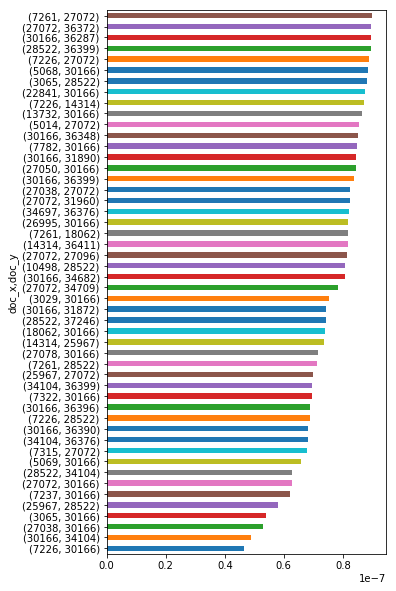

In [114]:
PMC = P.cosine.unstack().fillna(0)
PMC.head()
P.cosine.sort_values(ascending=True).head(50).plot(kind='barh', figsize=(5,10))

In [115]:
# Create a dataframe that unstacks PMC #
pmc_df = PMC.unstack()
pmc_df = pd.DataFrame(pmc_df)
pmc_df.doc_y = pmc_df.index
pmc_df = pmc_df.reset_index(level=['doc_y', 'doc_x'])
pmc_df = pmc_df.rename(columns={0:'Similarity'})

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  after removing the cwd from sys.path.


In [117]:
pmc_df.head()


,doc_y,doc_x,Similarity
0,2692,2691,0.022473
1,2692,2692,0.000000
2,2692,2693,0.000000
3,2692,2694,0.000000
4,2692,2695,0.000000


In [118]:
pmc_df.shape[0] # number of similaritiese to compare

6086089

In [141]:
len(pmc_df.doc_y.unique()) # 2467 different songs

2467

In [142]:
pmc_df_new = pmc_df
pmc_df_new.columns = ['doc_x','doc_y','Similarity']
pmc_df_merge = pmc_df.append(pmc_df_new)
# Get rid of similarities == 0 #
pmc_df_no_zero = pmc_df_merge[pmc_df_merge.Similarity > 0]

In [143]:
highest_sim = pmc_df_no_zero.groupby('doc_y')[['Similarity']].max().sort_values('Similarity',ascending=False)
highest_sim = highest_sim.reset_index(['doc_y'])
highest_sim.tail()

,doc_y,Similarity
2462,22867,0.027187
2463,37251,0.023941
2464,36405,0.020722
2465,36411,0.020590
2466,36390,0.015829


In [145]:
sim_merge = pd.merge(highest_sim, pmc_df_merge, how='inner', on=['doc_y','Similarity'])

In [147]:
# drop duplicate rows #
sim_merge_no_dup = sim_merge.drop_duplicates()
sim_merge_no_dup.shape[0]

2477

In [148]:
sim_merge_no_dup.head()

,doc_y,Similarity,doc_x
0,31892,1.0,31926
2,4849,1.0,4899
4,25951,1.0,25952
6,18092,1.0,18093
8,27003,1.0,27004


In [149]:
# read in data that includes the names of the songs and artists
artist_song_df = pd.read_csv('songs_key.csv')
artist_song_df = artist_song_df.drop(columns=['Unnamed: 0', 'text'])
just_artists_df=pd.read_csv('artists_key.csv')
just_artists_df.columns=['artist_id','artist']
artist_song_df=pd.merge(artist_song_df,just_artists_df)

In [150]:
first_merge_df = pd.merge(sim_merge_no_dup, artist_song_df, left_on='doc_y', right_on='song_id')
first_merge_df = first_merge_df.rename(columns={'artist':'artist_y','song':'song_y','artist_id':'artist_id_y'})
first_merge_df = first_merge_df.drop(columns='song_id')

In [151]:
first_merge_df.shape[0]

2477

In [152]:
second_merge_df = pd.merge(first_merge_df, artist_song_df, left_on='doc_x', right_on='song_id')
second_merge_df = second_merge_df.rename(columns={'artist':'artist_x','song':'song_x','artist_id':'artist_id_x'})
second_merge_df = second_merge_df.drop(columns='song_id')

In [154]:
# look at doc_y column #
second_merge_df.artist_y.unique()

array(['Status Quo', 'Kenny Loggins', 'Richard Marx', 'Gino Vannelli',
       'Chris Rea', 'Otis Redding', 'Christina Aguilera', 'Nick Drake',
       'Pet Shop Boys', 'Diana Ross', 'Queen', 'Maroon 5', 'Rem',
       'Uriah Heep', 'U2', 'Doors', 'Hollies', 'Weird Al Yankovic',
       'Chris Brown', 'Don McLean', 'Imago', 'Christmas Songs',
       'The Monkees', 'Rammstein', 'Fifth Harmony', 'Phil Collins',
       'Les Miserables', 'Divine', 'Queen Latifah', 'Independence Day',
       'Foreigner', 'Black Sabbath', 'Michael Buble', 'Willie Nelson',
       'Weezer', 'Bob Marley', 'Zayn Malik', 'Wyclef Jean', 'Zakk Wylde',
       'Van Der Graaf Generator'], dtype=object)

In [156]:
second_merge_df.head()

,doc_y,Similarity,doc_x,artist_y,song_y,artist_id_y,artist_x,song_x,artist_id_x
0,31892,1.000000,31926,Status Quo,Ice In The Sun,477,Status Quo,Are You Growing Tired Of My Love,477
1,18027,0.326831,31926,Kenny Loggins,Growin',270,Status Quo,Are You Growing Tired Of My Love,477
2,18106,0.281656,31926,Kenny Loggins,When I Was A Child,270,Status Quo,Are You Growing Tired Of My Love,477
3,31888,0.251654,31926,Status Quo,I Can Hear The Grass Grow,477,Status Quo,Are You Growing Tired Of My Love,477
4,30307,0.212644,31926,Richard Marx,Heart Of My Own,452,Status Quo,Are You Growing Tired Of My Love,477


In [161]:
#only show similarities between different artists
diff_artist_sim_df = second_merge_df[~(second_merge_df['artist_id_y'] == second_merge_df['artist_id_x'])]

In [162]:
diff_artist_sim_df.head(50)

,doc_y,Similarity,doc_x,artist_y,song_y,artist_id_y,artist_x,song_x,artist_id_x
1,18027,0.326831,31926,Kenny Loggins,Growin',270,Status Quo,Are You Growing Tired Of My Love,477
2,18106,0.281656,31926,Kenny Loggins,When I Was A Child,270,Status Quo,Are You Growing Tired Of My Love,477
4,30307,0.212644,31926,Richard Marx,Heart Of My Own,452,Status Quo,Are You Growing Tired Of My Love,477
5,11635,0.169481,31926,Gino Vannelli,Where Am I Going,172,Status Quo,Are You Growing Tired Of My Love,477
9,4961,0.357505,25952,Christina Aguilera,I Got Trouble,66,Otis Redding,Ole Man Trouble,383
10,24254,0.204660,25952,Nick Drake,Time Has Told Me,354,Otis Redding,Ole Man Trouble,383
14,7259,0.484767,25933,Diana Ross,Mean Ole Lion,96,Otis Redding,Any Ole Way - Live,383
15,18084,0.117377,25933,Kenny Loggins,Hana Aluna Lullabye,270,Otis Redding,Any Ole Way - Live,383
17,21549,0.218964,28528,Maroon 5,Shoot Love,319,Queen,One Year Of Love,424
18,30166,0.962644,34709,Rem,Passenger (As Performed On BBC's 'Later' With ...,450,Uriah Heep,Love Or Nothing,533
